In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
ticker = yf.Ticker("AAPL")
expiration_dates = ticker.options
exp_date = expiration_dates[4]  #1 month expiry
option_chain = ticker.option_chain(exp_date)
calls = option_chain.calls
puts = option_chain.puts
print("Calls:\n", calls.head())
print("Puts:\n", puts.tail())

Calls:
         contractSymbol             lastTradeDate  strike  lastPrice    bid  \
0  AAPL250627C00110000 2025-05-23 18:20:54+00:00   110.0      85.80  85.40   
1  AAPL250627C00140000 2025-05-23 19:26:29+00:00   140.0      56.29  55.85   
2  AAPL250627C00150000 2025-05-23 19:26:06+00:00   150.0      46.75  46.10   
3  AAPL250627C00165000 2025-05-23 15:32:16+00:00   165.0      33.52  31.90   
4  AAPL250627C00170000 2025-05-23 19:01:45+00:00   170.0      27.76  27.40   

     ask     change  percentChange  volume  openInterest  impliedVolatility  \
0  86.60 -10.849998     -11.226071     1.0             7           1.063481   
1  56.95  56.290000            NaN  7171.0             0           0.735842   
2  47.20  -7.310001     -13.522016    11.0            34           0.642093   
3  32.40 -14.660000     -30.427563     5.0             1           0.501470   
4  27.80  -6.400000     -18.735363    13.0             4           0.484991   

   inTheMoney contractSize currency  
0        T

In [3]:
#Contracts are chosen whose strikes are closer to current spot 
print(f'Chosen Call Contract: {calls['contractSymbol'].iloc[-25]} \t Strike: {calls['strike'].iloc[-25]} \t Price: {calls['lastPrice'].iloc[-25]}')
print(f'Chosen Put Contract: {puts['contractSymbol'].iloc[-10]} \t Strike: {puts['strike'].iloc[-10]} \t Price: {puts['lastPrice'].iloc[-10]}')
call_strike=int(calls['strike'].iloc[-25])
put_strike=int(puts['strike'].iloc[-10])

Chosen Call Contract: AAPL250627C00190000 	 Strike: 190.0 	 Price: 11.85
Chosen Put Contract: AAPL250627P00200000 	 Strike: 200.0 	 Price: 10.02


In [4]:
df=yf.download('AAPL',start='2024-05-24',end='2025-05-24',auto_adjust=False)
df=df.reset_index()
df['Date']=pd.to_datetime(df['Date'])
df=df.set_index('Date')
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2024-05-24,189.095657,189.979996,190.580002,188.039993,188.820007,36294600
2024-05-28,189.105606,189.990005,193.000000,189.100006,191.509995,52280100
2024-05-29,189.404221,190.289993,192.250000,189.509995,189.610001,53068000
2024-05-30,190.399567,191.289993,192.179993,190.630005,190.759995,49947900
2024-05-31,191.355103,192.250000,192.570007,189.910004,191.440002,75158300


In [5]:
df['Returns']=df['Adj Close']/df['Adj Close'].shift(1) - 1
df = df.drop(labels='2024-05-24')
df.head()

Price,Adj Close,Close,High,Low,Open,Volume,Returns
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,
Date,,,,,,,
2024-05-28,189.105606,189.990005,193.000000,189.100006,191.509995,52280100,0.000053
2024-05-29,189.404221,190.289993,192.250000,189.509995,189.610001,53068000,0.001579
2024-05-30,190.399567,191.289993,192.179993,190.630005,190.759995,49947900,0.005255
2024-05-31,191.355103,192.250000,192.570007,189.910004,191.440002,75158300,0.005019
2024-06-03,193.126816,194.029999,194.990005,192.520004,192.899994,50080500,0.009259


In [6]:
temp_spot=df['Adj Close'].iloc[-1]     #Current Stock Price
spot=float(temp_spot.iloc[0])
stdev=(df['Returns'].std())*(252**0.5)  #Standard deviation of returns

In [28]:
T=26/252     #26 days to expiry
t=1/252     #Time increment in simulations (1 day)
r=0.0436    #1 month US Treasury Bill Rate (Risk free rate)
drift=np.mean(df['Returns'])    #Long term mean spot price
simulations=1000

Geometric Brownian Motion: S(t)=S(t-1)*e**(drift-variance/2)*t + stdev*(square root(t))*Z

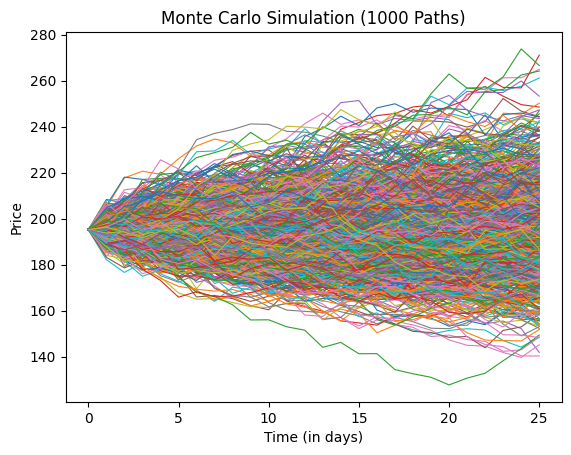

In [45]:
#Simulating Spot Prices
sim=[]
for i in range(simulations):
    sim.append([spot])
for i in range(simulations):
    for j in range(1,26):    #Simulating 26 day's prices
        sim[i].append(float(sim[i][j-1]*np.exp((drift-(stdev**2)/2)*t + stdev*t**0.5*np.random.normal(0,1))))
#Plot Spot Prices
for path in sim:
    plt.plot(path, linewidth=0.8) 
plt.title("Monte Carlo Simulation (1000 Paths)")
plt.xlabel("Time (in days)")
plt.ylabel("Price")
plt.show()

In [33]:
#Call Payoff
call_payoff=[]
for i in range(1000):
    call_payoff.append(max(sim[i][-1]-call_strike,0))
avg_call_payoff=sum(call_payoff)/len(call_payoff)
discounted_call_payoff=avg_call_payoff*np.exp(-r*T)
#Put Payoff
put_payoff=[]
for i in range(1000):
    put_payoff.append(max(put_strike-sim[i][-1],0))
avg_put_payoff=sum(put_payoff)/len(put_payoff)
discounted_put_payoff=avg_put_payoff*np.exp(-r*T)
print(f'Fair Call Price: {round(discounted_call_payoff,2)}\nFair Put Price: {round(discounted_put_payoff,2)}')

Fair Call Price: 10.4
Fair Put Price: 11.21


Conclusion: Call option is overpriced. Put option is underpriced.